# LightGBM

XGBoost의 최대 단점은 수행시간이 오래 걸림 -> 이로인해 GridSearchCV를 활용하여 튜닝이 어려움  
LightGBM은 XGBoost보다 학습 수행시간이 적으며 메모리 사용량도 상대적으로 적음  

<br>

하지만 예측 성능에 대한 차이는 없음  
또한 기능상 다양성이 LightGBM이 다소 더 다양함  
단점으로는 10,000건 이하의 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움  

<br>

LightGBM은 리프 중심 트리 분할(Leaf Wise)방식을 사용 -> 수평적 방식  
기존의 대부분 트리 기반 모델은 트리의 깊이를 줄이기 위해 균형 트리 분할(Level Wise)방식을 사용 -> 수직적 방식  
수직적 방식의 장점은 오버피팅에 더 강한 구조를 가질 수 있음  
반대로 균형을 맞추기 위한 시간이 필요하다는 상대적 단점이 있음  
LightGBM의 리프 중심 트리 분할 방식은 트리의 균형을 맞추지 않음  
대신 최대 손실 값(Max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적 규칙 트리가 생성됨  
하지만 최대 손실값을 가지는 리프노드를 지속적으로 분할해 생성된 규칙 트리는 반복할수록 결국 균형트리 방식보다 예측 오류 손실을 최소화 할수 있다는 것이 기본 concept

LightGBM의 XGBoost 대비 장점은
- 더 빠른 학습과 예측 수행시간
- 더 작은 메모리 사용량
- 카테고리형 피처의 자동 변환과 최적 분할  
(원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)  

LightGBM은 대용량 데이터에 뛰어난 예측 성능 및 병렬 컴퓨팅 기능을 제공하고 있으며, 최근에는 GPU까지 지원함  

<br>

LightGBM 또한 파이썬 래퍼용만 개발되었지만 사이킷런 래퍼도 개발됨  
사이킷런의 기반 Estimator를 상속받아 작성된 래퍼는 fit( ), predict( ) 기반의 학습 및 예측과 사이킷런이 제공하는 다양한 유틸리티의 활용이 가능

## LightGBM 하이퍼 파라미터

### 주요 파라미터
![image](https://user-images.githubusercontent.com/70187490/129435030-1fb7f1c5-3847-492f-a3a5-81f220201221.png)
![image](https://user-images.githubusercontent.com/70187490/129435044-cfd3e6e9-e3b8-470d-972e-8a8fd786d5e7.png)

### Learning Task 파라미터

![image](https://user-images.githubusercontent.com/70187490/129435097-2e669ef8-3994-4318-aaa2-32a8879a7de0.png)

## 하이퍼 파라미터 튜닝 방안
num_leaves의 개수를 중심으로 min_child_samples(min_data_in_leaf), max_depth를 함께 조정하면서 모델 복잡도를 줄이는 것이 기본 튜닝 방안
- num_leaves는 개별 트리가 가질 수 있는 최대 리프의 개수이고 LightGBM 모델의 복잡도를 제어하는 주요 파라미터.  
일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커짐
- min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀜  
과적합을 개선하기 위한 중요한 파라미터  
num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지함
- max_depth는 명시적으로 깊이의 크기를 제한함  
num_leaves, min_data_in_leaf와 결합해 과적합을 개선하는 데 사용함  

learning_rate를 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방식  
그러나 n_estimators를 너무 크게 하는 것은 과적합이므로 오히려 성능이 저하될 수 있음  
이밖에 과적합을 제어하기 위해서 reg_lambda, reg_alpha와 같은 regularization을 적용하거나  
학습 데이터에 사용할 피처의 개수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample 파라미터를 적용할 수 있음

## 파이썬 LightGBM과 사이킷런 XGBoost, LightGBM 하이퍼 파라미터 비교
![image](https://user-images.githubusercontent.com/70187490/129435730-8c0747a5-da33-4685-90d6-c444acdbd7e7.png)

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confusion, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confusion.shape[0]):
        for z in range(confusion.shape[1]):
            ax.text(x=z, y=i, s= confusion[i,z], va='center', ha='center', fontsize=19)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [2]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, 
                 eval_metric="logloss", eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_loglo

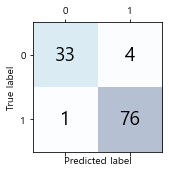

정확도: 0.9561, 정밀도: 0.9500, 재현율: 0.9870, F1: 0.9682, AUC: 0.9905


In [6]:
get_clf_eval(y_test, preds, pred_proba)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

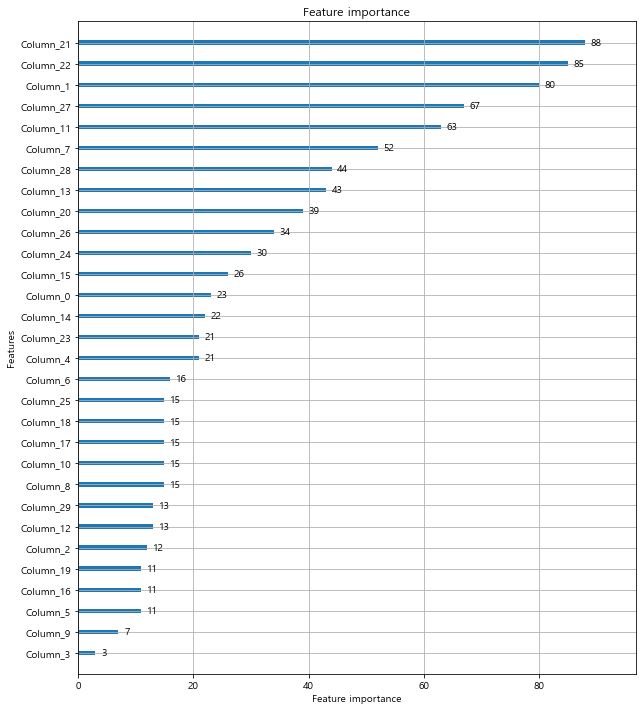

In [8]:
# plot_importance( )를 이용해 피처 중요도 시각화
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)